# Import dependencies

In [1]:
import os
import sys

sys.path.insert(0, os.path.dirname(os.getcwd())) 

In [2]:
import time
import gc
import json

import numpy as np
import pandas as pd

from transformers import BertTokenizer, BertModel
from transformers import logging

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from InputDataset import InputDataset

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt

from torch import cuda

from absa_models.ABSA_BERT_Dropout_BiLSTM_Linear import ABSA_BERT_Dropout_BiLSTM_Linear

In [3]:
device = 'cuda' if cuda.is_available() else 'cpu'
logging.set_verbosity_error() 

In [4]:
print(torch.cuda.get_device_name(0))
print(f"Memory: {torch.cuda.get_device_properties(0).total_memory // 1024 ** 3} GB")

NVIDIA GeForce RTX 2060 SUPER
Memory: 8 GB


In [5]:
def clear_memory():
    torch.cuda.empty_cache()

    with torch.no_grad():
        torch.cuda.empty_cache()

    gc.collect()

# Load Data

In [6]:
DATASET = 'ABSA_SemEval16_Restaurants_train.json'

In [7]:
df = pd.json_normalize(json.load(open(DATASET)))

In [8]:
df.head()

,text,tokens,absa_tags
0,Judging from previous posts this used to be a ...,"[Judging, from, previous, posts, this, used, t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,"We, there were four of us, arrived at noon - t...","[We, ,, there, were, four, of, us, ,, arrived,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"They never brought us complimentary noodles, i...","[They, never, brought, us, complimentary, nood...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,The food was lousy - too sweet or too salty an...,"[The, food, was, lousy, -, too, sweet, or, too...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,The food was lousy - too sweet or too salty an...,"[The, food, was, lousy, -, too, sweet, or, too...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


# Train & Validate

In [9]:
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4

EPOCHS = 2

LEARNING_RATE = 1e-5

TRAIN_SPLIT = 0.8
SEQ_LEN = 512

NO_RUNS = 10

In [10]:
BERT_FINE_TUNED_PATH = '../../../results/ABSA/SemEval16 - Task 5 - Restaurants/models/bert_fine_tuned_512.pth'

In [11]:
MODEL_OUTPUT = '../../../results/ABSA/SemEval16 - Task 5 - Restaurants/models/bert_fine_tuned_dropout_bilstm_linear_512.pth'
STATS_OUTPUT = '../../../results/ABSA/SemEval16 - Task 5 - Restaurants/stats/bert_fine_tuned_dropout_bilstm_linear_512.csv'

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
best_accuracy = 0.0

In [14]:
def create_mini_batch(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors[0] = torch.nn.ConstantPad1d((0, SEQ_LEN - len(ids_tensors[0])), 0)(ids_tensors[0])
    ids_tensors = pad_sequence(ids_tensors, batch_first=True).to(device)

    tags_tensors = [s[2] for s in samples]
    tags_tensors[0] = torch.nn.ConstantPad1d((0, SEQ_LEN - len(tags_tensors[0])), 0)(tags_tensors[0])
    tags_tensors = pad_sequence(tags_tensors, batch_first=True).to(device)
    
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long).to(device)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1).to(device)
    
    return ids_tensors, tags_tensors, masks_tensors

In [15]:
def train(epoch, model, loss_fn, optimizer, dataloader):
    model.train()

    dataloader_len = len(dataloader)

    losses = []

    for _,data in enumerate(dataloader, 0):
        optimizer.zero_grad()

        ids_tensors, tags_tensors, masks_tensors = data

        outputs = model(ids_tensors, masks_tensors)

        loss = loss_fn(outputs.view(-1, 4), tags_tensors.view(-1))

        losses.append(loss.item())
        
        if _ % (dataloader_len // 10) == 0:
            print(f"Epoch: {epoch}/{EPOCHS}, Batch: {_}/{dataloader_len}, Loss: {loss.item()}")
        
        loss.backward()
        
        optimizer.step()
    
    return losses

In [16]:
def validation(model, dataloader):
    model.eval()
    
    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad():
        for _, data in enumerate(dataloader, 0):
            ids_tensors, tags_tensors, masks_tensors = data
            ids_tensors = ids_tensors.to(device)
            tags_tensors = tags_tensors.to(device)
            masks_tensors = masks_tensors.to(device)

            outputs = model(ids_tensors, masks_tensors)
            
            _, predictions = torch.max(outputs, dim=2)

            fin_outputs += list([int(p) for pred in predictions for p in pred])
            fin_targets += list([int(tag) for tags_tensor in tags_tensors for tag in tags_tensor])

    return fin_outputs, fin_targets

In [17]:
results = pd.DataFrame(columns=['accuracy','precision_score_micro','precision_score_macro','recall_score_micro','recall_score_macro','f1_score_micro','f1_score_macro', 'execution_time'])

Run 1/10
Epoch: 0/2, Batch: 0/501, Loss: 1.4160181283950806
Epoch: 0/2, Batch: 50/501, Loss: 0.09764713793992996
Epoch: 0/2, Batch: 100/501, Loss: 0.050754111260175705
Epoch: 0/2, Batch: 150/501, Loss: 0.047494105994701385
Epoch: 0/2, Batch: 200/501, Loss: 0.029619457200169563
Epoch: 0/2, Batch: 250/501, Loss: 0.01904434710741043
Epoch: 0/2, Batch: 300/501, Loss: 0.02699730359017849
Epoch: 0/2, Batch: 350/501, Loss: 0.013693219050765038
Epoch: 0/2, Batch: 400/501, Loss: 0.016435865312814713
Epoch: 0/2, Batch: 450/501, Loss: 0.01723906397819519
Epoch: 0/2, Batch: 500/501, Loss: 0.016802221536636353
Epoch: 1/2, Batch: 0/501, Loss: 0.011550858616828918
Epoch: 1/2, Batch: 50/501, Loss: 0.010876961052417755
Epoch: 1/2, Batch: 100/501, Loss: 0.015487651340663433
Epoch: 1/2, Batch: 150/501, Loss: 0.011951710097491741
Epoch: 1/2, Batch: 200/501, Loss: 0.012954102829098701
Epoch: 1/2, Batch: 250/501, Loss: 0.016347920522093773
Epoch: 1/2, Batch: 300/501, Loss: 0.0060795568861067295
Epoch: 1/2, 

d:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 2/10
Epoch: 0/2, Batch: 0/501, Loss: 1.4954779148101807
Epoch: 0/2, Batch: 50/501, Loss: 0.08985355496406555
Epoch: 0/2, Batch: 100/501, Loss: 0.044185392558574677
Epoch: 0/2, Batch: 150/501, Loss: 0.03621222823858261
Epoch: 0/2, Batch: 200/501, Loss: 0.026193395256996155
Epoch: 0/2, Batch: 250/501, Loss: 0.019789088517427444
Epoch: 0/2, Batch: 300/501, Loss: 0.016681525856256485
Epoch: 0/2, Batch: 350/501, Loss: 0.011207738891243935
Epoch: 0/2, Batch: 400/501, Loss: 0.018531451001763344
Epoch: 0/2, Batch: 450/501, Loss: 0.011783374473452568
Epoch: 0/2, Batch: 500/501, Loss: 0.016660239547491074
Epoch: 1/2, Batch: 0/501, Loss: 0.011033198796212673
Epoch: 1/2, Batch: 50/501, Loss: 0.009529921226203442
Epoch: 1/2, Batch: 100/501, Loss: 0.010631829500198364
Epoch: 1/2, Batch: 150/501, Loss: 0.00635976018384099
Epoch: 1/2, Batch: 200/501, Loss: 0.012399588711559772
Epoch: 1/2, Batch: 250/501, Loss: 0.007852215319871902
Epoch: 1/2, Batch: 300/501, Loss: 0.012678368017077446
Epoch: 1/2, 

d:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 3/10
Epoch: 0/2, Batch: 0/501, Loss: 1.371009349822998
Epoch: 0/2, Batch: 50/501, Loss: 0.11788313090801239
Epoch: 0/2, Batch: 100/501, Loss: 0.04730416089296341
Epoch: 0/2, Batch: 150/501, Loss: 0.034519121050834656
Epoch: 0/2, Batch: 200/501, Loss: 0.02109537087380886
Epoch: 0/2, Batch: 250/501, Loss: 0.030138378962874413
Epoch: 0/2, Batch: 300/501, Loss: 0.033458150923252106
Epoch: 0/2, Batch: 350/501, Loss: 0.01974313333630562
Epoch: 0/2, Batch: 400/501, Loss: 0.01712222397327423
Epoch: 0/2, Batch: 450/501, Loss: 0.012828175909817219
Epoch: 0/2, Batch: 500/501, Loss: 0.009728200733661652
Epoch: 1/2, Batch: 0/501, Loss: 0.01438331138342619
Epoch: 1/2, Batch: 50/501, Loss: 0.006261201109737158
Epoch: 1/2, Batch: 100/501, Loss: 0.01222167257219553
Epoch: 1/2, Batch: 150/501, Loss: 0.021664924919605255
Epoch: 1/2, Batch: 200/501, Loss: 0.00904060248285532
Epoch: 1/2, Batch: 250/501, Loss: 0.015414783731102943
Epoch: 1/2, Batch: 300/501, Loss: 0.007554196752607822
Epoch: 1/2, Batch:

d:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 4/10
Epoch: 0/2, Batch: 0/501, Loss: 1.356939673423767
Epoch: 0/2, Batch: 50/501, Loss: 0.08350823819637299
Epoch: 0/2, Batch: 100/501, Loss: 0.051877494901418686
Epoch: 0/2, Batch: 150/501, Loss: 0.03495687618851662
Epoch: 0/2, Batch: 200/501, Loss: 0.029758324846625328
Epoch: 0/2, Batch: 250/501, Loss: 0.014933864586055279
Epoch: 0/2, Batch: 300/501, Loss: 0.017482256516814232
Epoch: 0/2, Batch: 350/501, Loss: 0.015951499342918396
Epoch: 0/2, Batch: 400/501, Loss: 0.011053580790758133
Epoch: 0/2, Batch: 450/501, Loss: 0.010113660246133804
Epoch: 0/2, Batch: 500/501, Loss: 0.011676869355142117
Epoch: 1/2, Batch: 0/501, Loss: 0.015645910054445267
Epoch: 1/2, Batch: 50/501, Loss: 0.017956944182515144
Epoch: 1/2, Batch: 100/501, Loss: 0.011137938126921654
Epoch: 1/2, Batch: 150/501, Loss: 0.004564984701573849
Epoch: 1/2, Batch: 200/501, Loss: 0.01760667748749256
Epoch: 1/2, Batch: 250/501, Loss: 0.012166776694357395
Epoch: 1/2, Batch: 300/501, Loss: 0.006632545497268438
Epoch: 1/2, B

d:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 5/10
Epoch: 0/2, Batch: 0/501, Loss: 1.5269463062286377
Epoch: 0/2, Batch: 50/501, Loss: 0.10232920199632645
Epoch: 0/2, Batch: 100/501, Loss: 0.050335001200437546
Epoch: 0/2, Batch: 150/501, Loss: 0.029267586767673492
Epoch: 0/2, Batch: 200/501, Loss: 0.028047924861311913
Epoch: 0/2, Batch: 250/501, Loss: 0.030890194699168205
Epoch: 0/2, Batch: 300/501, Loss: 0.02363390475511551
Epoch: 0/2, Batch: 350/501, Loss: 0.01874867081642151
Epoch: 0/2, Batch: 400/501, Loss: 0.008475757203996181
Epoch: 0/2, Batch: 450/501, Loss: 0.01067313551902771
Epoch: 0/2, Batch: 500/501, Loss: 0.012432088144123554
Epoch: 1/2, Batch: 0/501, Loss: 0.00945048313587904
Epoch: 1/2, Batch: 50/501, Loss: 0.014816437847912312
Epoch: 1/2, Batch: 100/501, Loss: 0.013765452429652214
Epoch: 1/2, Batch: 150/501, Loss: 0.010296712629497051
Epoch: 1/2, Batch: 200/501, Loss: 0.010135309770703316
Epoch: 1/2, Batch: 250/501, Loss: 0.009623143821954727
Epoch: 1/2, Batch: 300/501, Loss: 0.013288886286318302
Epoch: 1/2, Ba

d:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 6/10
Epoch: 0/2, Batch: 0/501, Loss: 1.5418730974197388
Epoch: 0/2, Batch: 50/501, Loss: 0.10056766122579575
Epoch: 0/2, Batch: 100/501, Loss: 0.06871172785758972
Epoch: 0/2, Batch: 150/501, Loss: 0.058197665959596634
Epoch: 0/2, Batch: 200/501, Loss: 0.0402650311589241
Epoch: 0/2, Batch: 250/501, Loss: 0.03119044378399849
Epoch: 0/2, Batch: 300/501, Loss: 0.014803947880864143
Epoch: 0/2, Batch: 350/501, Loss: 0.018366863951086998
Epoch: 0/2, Batch: 400/501, Loss: 0.017138086259365082
Epoch: 0/2, Batch: 450/501, Loss: 0.012712445110082626
Epoch: 0/2, Batch: 500/501, Loss: 0.014801232144236565
Epoch: 1/2, Batch: 0/501, Loss: 0.0296611525118351
Epoch: 1/2, Batch: 50/501, Loss: 0.010285728611052036
Epoch: 1/2, Batch: 100/501, Loss: 0.017126617953181267
Epoch: 1/2, Batch: 150/501, Loss: 0.013215727172791958
Epoch: 1/2, Batch: 200/501, Loss: 0.012659328989684582
Epoch: 1/2, Batch: 250/501, Loss: 0.004429415334016085
Epoch: 1/2, Batch: 300/501, Loss: 0.01185275986790657
Epoch: 1/2, Batch

d:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 7/10
Epoch: 0/2, Batch: 0/501, Loss: 1.4861468076705933
Epoch: 0/2, Batch: 50/501, Loss: 0.09987897425889969
Epoch: 0/2, Batch: 100/501, Loss: 0.05739479511976242
Epoch: 0/2, Batch: 150/501, Loss: 0.03396763280034065
Epoch: 0/2, Batch: 200/501, Loss: 0.044001031666994095
Epoch: 0/2, Batch: 250/501, Loss: 0.02146872878074646
Epoch: 0/2, Batch: 300/501, Loss: 0.027159342542290688
Epoch: 0/2, Batch: 350/501, Loss: 0.018528027459979057
Epoch: 0/2, Batch: 400/501, Loss: 0.019290901720523834
Epoch: 0/2, Batch: 450/501, Loss: 0.011800379492342472
Epoch: 0/2, Batch: 500/501, Loss: 0.013818956911563873
Epoch: 1/2, Batch: 0/501, Loss: 0.01481364294886589
Epoch: 1/2, Batch: 50/501, Loss: 0.011515031568706036
Epoch: 1/2, Batch: 100/501, Loss: 0.013432466425001621
Epoch: 1/2, Batch: 150/501, Loss: 0.009666378609836102
Epoch: 1/2, Batch: 200/501, Loss: 0.021779103204607964
Epoch: 1/2, Batch: 250/501, Loss: 0.007420989219099283
Epoch: 1/2, Batch: 300/501, Loss: 0.01145933661609888
Epoch: 1/2, Bat

d:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 8/10
Epoch: 0/2, Batch: 0/501, Loss: 1.465604543685913
Epoch: 0/2, Batch: 50/501, Loss: 0.10753703117370605
Epoch: 0/2, Batch: 100/501, Loss: 0.06916847825050354
Epoch: 0/2, Batch: 150/501, Loss: 0.03717230260372162
Epoch: 0/2, Batch: 200/501, Loss: 0.029086574912071228
Epoch: 0/2, Batch: 250/501, Loss: 0.03230784088373184
Epoch: 0/2, Batch: 300/501, Loss: 0.023374365642666817
Epoch: 0/2, Batch: 350/501, Loss: 0.017528094351291656
Epoch: 0/2, Batch: 400/501, Loss: 0.009870370849967003
Epoch: 0/2, Batch: 450/501, Loss: 0.012677897699177265
Epoch: 0/2, Batch: 500/501, Loss: 0.01760617271065712
Epoch: 1/2, Batch: 0/501, Loss: 0.011427679099142551
Epoch: 1/2, Batch: 50/501, Loss: 0.01783422753214836
Epoch: 1/2, Batch: 100/501, Loss: 0.01147496234625578
Epoch: 1/2, Batch: 150/501, Loss: 0.012714375741779804
Epoch: 1/2, Batch: 200/501, Loss: 0.016276106238365173
Epoch: 1/2, Batch: 250/501, Loss: 0.012552116997539997
Epoch: 1/2, Batch: 300/501, Loss: 0.008850058540701866
Epoch: 1/2, Batch

d:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 9/10
Epoch: 0/2, Batch: 0/501, Loss: 1.3318455219268799
Epoch: 0/2, Batch: 50/501, Loss: 0.09162372350692749
Epoch: 0/2, Batch: 100/501, Loss: 0.04467524588108063
Epoch: 0/2, Batch: 150/501, Loss: 0.04706394672393799
Epoch: 0/2, Batch: 200/501, Loss: 0.02622886933386326
Epoch: 0/2, Batch: 250/501, Loss: 0.028227349743247032
Epoch: 0/2, Batch: 300/501, Loss: 0.02286520227789879
Epoch: 0/2, Batch: 350/501, Loss: 0.013971686363220215
Epoch: 0/2, Batch: 400/501, Loss: 0.012332949787378311
Epoch: 0/2, Batch: 450/501, Loss: 0.02235868200659752
Epoch: 0/2, Batch: 500/501, Loss: 0.027084220200777054
Epoch: 1/2, Batch: 0/501, Loss: 0.0096952635794878
Epoch: 1/2, Batch: 50/501, Loss: 0.009233304299414158
Epoch: 1/2, Batch: 100/501, Loss: 0.009077331982553005
Epoch: 1/2, Batch: 150/501, Loss: 0.008402279578149319
Epoch: 1/2, Batch: 200/501, Loss: 0.007791356183588505
Epoch: 1/2, Batch: 250/501, Loss: 0.008364912122488022
Epoch: 1/2, Batch: 300/501, Loss: 0.005226483568549156
Epoch: 1/2, Batch

d:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 10/10
Epoch: 0/2, Batch: 0/501, Loss: 1.5564746856689453
Epoch: 0/2, Batch: 50/501, Loss: 0.10287591069936752
Epoch: 0/2, Batch: 100/501, Loss: 0.05388101935386658
Epoch: 0/2, Batch: 150/501, Loss: 0.031917065382003784
Epoch: 0/2, Batch: 200/501, Loss: 0.02633718028664589
Epoch: 0/2, Batch: 250/501, Loss: 0.01833106018602848
Epoch: 0/2, Batch: 300/501, Loss: 0.01857588440179825
Epoch: 0/2, Batch: 350/501, Loss: 0.012651031836867332
Epoch: 0/2, Batch: 400/501, Loss: 0.019589468836784363
Epoch: 0/2, Batch: 450/501, Loss: 0.017725514248013496
Epoch: 0/2, Batch: 500/501, Loss: 0.011628963053226471
Epoch: 1/2, Batch: 0/501, Loss: 0.019771892577409744
Epoch: 1/2, Batch: 50/501, Loss: 0.010542676784098148
Epoch: 1/2, Batch: 100/501, Loss: 0.015229884535074234
Epoch: 1/2, Batch: 150/501, Loss: 0.006371872499585152
Epoch: 1/2, Batch: 200/501, Loss: 0.009052343666553497
Epoch: 1/2, Batch: 250/501, Loss: 0.008084528148174286
Epoch: 1/2, Batch: 300/501, Loss: 0.012975954450666904
Epoch: 1/2, B

d:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


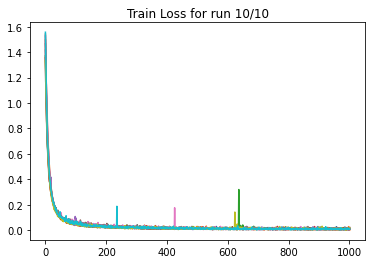

In [18]:
for i in range(NO_RUNS):
    # clear cache cuda
    torch.cuda.empty_cache()
    with torch.no_grad():
        torch.cuda.empty_cache()
    gc.collect()

    start_time = time.time()

    print(f"Run {i + 1}/{NO_RUNS}")

    train_dataset = df.sample(frac=TRAIN_SPLIT)
    test_dataset = df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    training_set = InputDataset(train_dataset, tokenizer)
    testing_set = InputDataset(test_dataset, tokenizer)

    train_dataloader = DataLoader(
        training_set,
        sampler = RandomSampler(train_dataset),
        batch_size = TRAIN_BATCH_SIZE,
        drop_last = True,
        collate_fn=create_mini_batch
    )

    validation_dataloader = DataLoader(
        testing_set,
        sampler = SequentialSampler(testing_set),
        batch_size = VALID_BATCH_SIZE,
        drop_last = True,
        collate_fn=create_mini_batch
    )

    model = ABSA_BERT_Dropout_BiLSTM_Linear(torch.load(BERT_FINE_TUNED_PATH), dropout=0.3, bilstm_in_features=256, no_out_labels=4, device=device).to(device)

    optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_losses = []

    for epoch in range(EPOCHS):
        losses = train(epoch, model, loss_fn, optimizer, train_dataloader)

        train_losses += losses
    
    plt.title(f'Train Loss for run {i + 1}/{NO_RUNS}')
    plt.plot(train_losses)
    plt.savefig(f'../../../results/ABSA/SemEval16 - Task 5 - Restaurants/plots/bert_ft_do_bilstm_lin/train_loss_run_{i + 1}.png')

    plt.clf()

    outputs, targets = validation(model, validation_dataloader)
    
    accuracy = accuracy_score(targets, outputs)
    precision_score_micro = precision_score(targets, outputs, average='micro')
    precision_score_macro = precision_score(targets, outputs, average='macro')
    recall_score_micro = recall_score(targets, outputs, average='micro')
    recall_score_macro = recall_score(targets, outputs, average='macro')
    f1_score_micro = f1_score(targets, outputs, average='micro')
    f1_score_macro = f1_score(targets, outputs, average='macro')

    execution_time = time.time() - start_time

    results.loc[i] = [accuracy,precision_score_micro,precision_score_macro,recall_score_micro,recall_score_macro,f1_score_micro,f1_score_macro, execution_time]

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model, MODEL_OUTPUT)

    del train_dataset
    del test_dataset
    del training_set
    del testing_set
    del model
    del loss_fn
    del optimizer
    del outputs
    del targets

In [19]:
results

,accuracy,precision_score_micro,precision_score_macro,recall_score_micro,recall_score_macro,f1_score_micro,f1_score_macro,execution_time
0,0.997508,0.997508,0.412147,0.997508,0.464009,0.997508,0.434507,368.461907
1,0.997609,0.997609,0.419087,0.997609,0.465068,0.997609,0.439329,360.888796
2,0.997172,0.997172,0.406802,0.997172,0.470092,0.997172,0.433121,384.175261
3,0.997371,0.997371,0.410671,0.997371,0.467657,0.997371,0.434873,361.389527
4,0.997156,0.997156,0.399511,0.997156,0.471796,0.997156,0.428609,343.502902
5,0.997145,0.997145,0.398154,0.997145,0.471888,0.997145,0.427663,374.658519
6,0.997555,0.997555,0.414223,0.997555,0.474977,0.997555,0.439852,377.665521
7,0.997547,0.997547,0.418121,0.997547,0.467981,0.997547,0.439837,335.450675
8,0.997824,0.997824,0.423553,0.997824,0.470815,0.997824,0.444354,336.420178
9,0.997328,0.997328,0.407040,0.997328,0.469222,0.997328,0.432994,335.548567


In [20]:
results.to_csv(STATS_OUTPUT)